In [1]:
import requests
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import pprint
from datetime import date
import moeximporter
from moeximporter import MoexImporter, MoexSecurity, MoexCandlePeriods

In [2]:
tickers = [
    'SBER', 'LKOH', 'GAZP', 'ALRS', 'FIVE', 'MGNT',
    'MTSS', 'NVTK', 'ROSN', 'TATN', 'VTBR',
    'YNDX', 'CHMF', 'GMKN', 'SNGS', 'AFLT'
]
# Компании голубые фишки (согласно индексу голубых фишек Московской фондовой биржи (https://www.moex.com/ru/index/MOEXBC)):
# Сбербанк
# ЛУКОЙЛ
# «Газпром»
# АЛРОСА
# X5 Retail Group
# «Магнит»
# МТС
# НОВАТЭК
# «Роснефть»
# «Татнефть»
# ВТБ
# «Яндекс»
# «Северсталь»
# «Норникель»
# «Сургутнефтегаз»
# «Аэрофлот»

In [3]:
mi = MoexImporter()
sec = MoexSecurity('GMKN', mi)
print(sec)


Security GMKN (ГМКНорНик)
Issued: 2006-12-26
Main board: TQBR (Т+: Акции и ДР - безадрес.)
Engine: stock
Market: shares
History for the main board is available from 2014-06-09 till 2025-05-02



Чтобы скорректировать котировки на сплиты, посмотрим на данных котировок акций как выглядят сплиты, чтобы потом провести коррекцию корректировок.

Из открытых источников мы знаем, что "7 декабря 2023 года внеочередное собрание акционеров одобрило дробление акций в соотношении 100-к-1. По словам финдиректора компании Сергея Малышева, сплит бумаг предварительно завершится в начале апреля. В результате их стоимость уменьшится в 100 раз". Посмотрим как выглядели котировки акций "Норникеля" в этот временной период:

In [6]:
quotes_df = sec.getHistoryQuotesAsDataFrame(date(2024, 3, 25), date(2024, 4, 12))
# quotes_df = sec.getHistoryQuotesAsDataFrame(date(2024, 10, 1), date(2025, 4, 30))

print(quotes_df.shape)
quotes_df.head(15)

(15, 7)


,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,QUANTITY
TRADEDATE,,,,,,,
2024-03-25,2.044875e+09,14800.00,14688.00,15258.00,14946.00,15258.00,136784
2024-03-26,1.751040e+09,15156.00,15016.00,15314.00,15150.00,15180.00,115591
2024-03-27,1.407316e+09,15164.00,15124.00,15300.00,15206.00,15280.00,92532
2024-03-28,1.072440e+09,15330.00,15120.00,15358.00,15210.00,15268.00,70524
2024-03-29,9.170651e+08,15250.00,15100.00,15250.00,15148.00,15180.00,60542
2024-04-01,8.061355e+08,15120.00,15048.00,15208.00,15152.00,15054.00,53208
2024-04-02,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0
2024-04-03,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0
2024-04-04,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0


Как мы видим, действительно, в апреле 2024 года было произведено дробление акций. Выкинем все дни с неопределенными котировками (nan).

In [8]:
quotes_df = quotes_df.dropna(subset=['CLOSE']) # выбрасываем строки с nan значениями (в эти дни производился сплит бумаг)

quotes_df.head(15)

,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,QUANTITY
TRADEDATE,,,,,,,
2024-03-25,2.044875e+09,14800.00,14688.00,15258.00,14946.00,15258.00,136784
2024-03-26,1.751040e+09,15156.00,15016.00,15314.00,15150.00,15180.00,115591
2024-03-27,1.407316e+09,15164.00,15124.00,15300.00,15206.00,15280.00,92532
2024-03-28,1.072440e+09,15330.00,15120.00,15358.00,15210.00,15268.00,70524
2024-03-29,9.170651e+08,15250.00,15100.00,15250.00,15148.00,15180.00,60542
2024-04-01,8.061355e+08,15120.00,15048.00,15208.00,15152.00,15054.00,53208
2024-04-08,3.151760e+09,152.50,152.26,156.38,153.98,153.00,20469920
2024-04-09,7.030479e+09,152.62,152.54,161.00,158.60,159.90,44328820
2024-04-10,5.449589e+09,164.00,161.10,165.80,163.62,163.50,33307590


In [9]:
ratio = quotes_df['CLOSE'].shift(1) / quotes_df['CLOSE']
ratio.head(15)

TRADEDATE
2024-03-25          NaN
2024-03-26     1.005138
2024-03-27     0.993455
2024-03-28     1.000786
2024-03-29     1.005797
2024-04-01     1.008370
2024-04-08    98.392157
2024-04-09     0.956848
2024-04-10     0.977982
2024-04-11     1.010757
2024-04-12     0.972934
Name: CLOSE, dtype: float64

Обычно дробление акций производится со стандартными соотношениями - 2:1, 3:1, 4:1 и тд. Например, Apple в 2020 году провела сплит 4:1. Бывают и экстремальные сплиты, как в случае с "Норникелем", где соотношение почти 100 к 1 (98,39).

Чтобы провести корректировку котировок акций на сплиты, будем считать, что произошел сплит, если отношение закрытия предыдущего дня к текущему >= 2.

In [11]:
quotes_df['split_ratio'] = np.where(ratio >= 2, 1/ratio, 1.0)
quotes_df.head(15)

,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,QUANTITY,split_ratio
TRADEDATE,,,,,,,,
2024-03-25,2.044875e+09,14800.00,14688.00,15258.00,14946.00,15258.00,136784,1.000000
2024-03-26,1.751040e+09,15156.00,15016.00,15314.00,15150.00,15180.00,115591,1.000000
2024-03-27,1.407316e+09,15164.00,15124.00,15300.00,15206.00,15280.00,92532,1.000000
2024-03-28,1.072440e+09,15330.00,15120.00,15358.00,15210.00,15268.00,70524,1.000000
2024-03-29,9.170651e+08,15250.00,15100.00,15250.00,15148.00,15180.00,60542,1.000000
2024-04-01,8.061355e+08,15120.00,15048.00,15208.00,15152.00,15054.00,53208,1.000000
2024-04-08,3.151760e+09,152.50,152.26,156.38,153.98,153.00,20469920,0.010163
2024-04-09,7.030479e+09,152.62,152.54,161.00,158.60,159.90,44328820,1.000000
2024-04-10,5.449589e+09,164.00,161.10,165.80,163.62,163.50,33307590,1.000000


In [12]:
quotes_df['split_ratio'].min()

0.010163411717815863

Теперь проведем корректировку:

In [14]:
def calculate_adjusted_prices(df, column):
    adj_price_col = 'adj_' + column
    adj_qty_col   = 'adj_QUANTITY'

    df = df.sort_index(ascending=False).copy()

    prices = df[column].values.astype(float)
    splits = df['split_ratio'].values.astype(float)
    qty    = df['QUANTITY'].values.astype(float)

    n = len(df)
    adj_prices = np.zeros(n, dtype=float)
    adj_qty    = np.zeros(n, dtype=float)

    adj_prices[0] = prices[0]
    adj_qty[0]    = qty[0]

    for i in range(1, n):
        r = splits[i-1]  # коэффициент сплита предыдущего дня
        # скорректированная цена: prev_adj * (price_i * r / price_{i-1})
        adj_prices[i] = round(adj_prices[i-1] * (prices[i] * r / prices[i-1]), 4)
        # скорректированный объём: prev_adj_qty * (qty_i / (qty_{i-1} * r))
        adj_qty[i]     = round(adj_qty[i-1]    * (qty[i]    / (qty[i-1] * r)), 4)

    df[adj_price_col] = adj_prices
    df[adj_qty_col]   = adj_qty

    return df.sort_index(ascending=True)

adjusted_df = calculate_adjusted_prices(quotes_df, 'CLOSE')
adjusted_df.head(15)

,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,QUANTITY,split_ratio,adj_CLOSE,adj_QUANTITY
TRADEDATE,,,,,,,,,,
2024-03-25,2.044875e+09,14800.00,14688.00,15258.00,14946.00,15258.00,136784,1.000000,155.0734,1.345847e+07
2024-03-26,1.751040e+09,15156.00,15016.00,15314.00,15150.00,15180.00,115591,1.000000,154.2807,1.137325e+07
2024-03-27,1.407316e+09,15164.00,15124.00,15300.00,15206.00,15280.00,92532,1.000000,155.2970,9.104423e+06
2024-03-28,1.072440e+09,15330.00,15120.00,15358.00,15210.00,15268.00,70524,1.000000,155.1750,6.939008e+06
2024-03-29,9.170651e+08,15250.00,15100.00,15250.00,15148.00,15180.00,60542,1.000000,154.2806,5.956858e+06
2024-04-01,8.061355e+08,15120.00,15048.00,15208.00,15152.00,15054.00,53208,1.000000,153.0000,5.235250e+06
2024-04-08,3.151760e+09,152.50,152.26,156.38,153.98,153.00,20469920,0.010163,153.0000,2.046992e+07
2024-04-09,7.030479e+09,152.62,152.54,161.00,158.60,159.90,44328820,1.000000,159.9000,4.432882e+07
2024-04-10,5.449589e+09,164.00,161.10,165.80,163.62,163.50,33307590,1.000000,163.5000,3.330759e+07


Теперь мы реализовали функционал для корректировки котировок на сплиты и показали как это работает на конкретном примере с "Норникелем". Теперь проделаем это со всеми голубыми фишками из списка:

In [16]:
tickers = [
    'SBER', 'LKOH', 'GAZP', 'ALRS', 'MGNT',
    'MTSS', 'NVTK', 'ROSN', 'TATN', 'VTBR',
    'YNDX', 'YDEX', 'CHMF', 'GMKN', 'SNGS', 'AFLT', 'PLZL'
] 
# Два Яндекса, потому что в мае 2024 года Yandex N.V. (юридическое лицо, выпускавшее акции YNDX)
# объявило о делистинге с Московской биржи. Новой головной компанией группы стало российское юрлицо МКПАО «Яндекс» , акции которого
# получили листинг на бирже под новым тикером YDEX 24 июля 2024 года

def calculate_adjusted_prices(df, column):
    adj_price_col = 'adj_' + column
    adj_qty_col   = 'adj_QUANTITY'

    df = df.sort_index(ascending=False).copy()

    prices = df[column].values.astype(float)
    splits = df['split_ratio'].values.astype(float)
    qty    = df['QUANTITY'].values.astype(float)

    n = len(df)
    adj_prices = np.zeros(n, dtype=float)
    adj_qty    = np.zeros(n, dtype=float)

    adj_prices[0] = prices[0]
    adj_qty[0]    = qty[0]

    for i in range(1, n):
        r = splits[i-1]  # коэффициент сплита предыдущего дня
        # скорректированная цена: prev_adj * (price_i * r / price_{i-1})
        adj_prices[i] = round(adj_prices[i-1] * (prices[i] * r / prices[i-1]), 4)
        # скорректированный объём: prev_adj_qty * (qty_i / (qty_{i-1} * r))
        adj_qty[i]     = round(adj_qty[i-1]    * (qty[i]    / (qty[i-1] * r)), 4)

    df[adj_price_col] = adj_prices
    df[adj_qty_col]   = adj_qty

    return df.sort_index(ascending=True)

adjusted_quotes = {}

mi = MoexImporter()

for ticker in tickers:
    sec = MoexSecurity(ticker, mi)
    try:
        df = sec.getHistoryQuotesAsDataFrame(
            date(2024, 10, 1), 
            date(2025, 4, 30)
        )
    except Exception:
        print(f'Для {ticker} котировки акций в указанный временной промежуток недоступны')
    # Убираем дни с NaN в CLOSE (сплиты)
    try:
        df = df.dropna(subset=['CLOSE'])
    except Exception:
        print(f'Для {ticker} данные недоступны')
        continue

    if df.shape[0] == 0:
        print(f"Нет данных для {ticker}, пропускаем")
        continue

    ratio = df['CLOSE'].shift(1) / df['CLOSE']
    df['split_ratio'] = np.where(ratio >= 2, 1/ratio, 1.0)
    adjusted_df = calculate_adjusted_prices(df, 'CLOSE')
    adjusted_quotes[ticker] = adjusted_df

# Пример: вывод первых строк скорректированных котировок Сбербанка
adjusted_quotes['SBER'].head()

MoexSecurity::getHistoryQuotesAsDataFrame():  "None of ['TRADEDATE'] are in the columns"


Для YNDX данные недоступны


,VALUE,OPEN,LOW,HIGH,WAPRICE,CLOSE,QUANTITY,split_ratio,adj_CLOSE,adj_QUANTITY
TRADEDATE,,,,,,,,,,
2024-10-01,1.270618e+10,267.60,264.00,268.68,266.19,266.85,47730650,1.0,266.85,47730650.0
2024-10-02,9.873300e+09,266.01,258.52,268.00,263.85,258.52,37420750,1.0,258.52,37420750.0
2024-10-03,1.345105e+10,259.31,257.20,264.33,260.81,263.01,51574880,1.0,263.01,51574880.0
2024-10-04,6.280923e+09,264.96,262.11,265.44,264.01,263.76,23792130,1.0,263.76,23792130.0
2024-10-07,6.966464e+09,264.25,261.37,267.00,263.24,262.60,26464220,1.0,262.60,26464220.0


In [17]:
print(adjusted_quotes.keys())

dict_keys(['SBER', 'LKOH', 'GAZP', 'ALRS', 'MGNT', 'MTSS', 'NVTK', 'ROSN', 'TATN', 'VTBR', 'YDEX', 'CHMF', 'GMKN', 'SNGS', 'AFLT', 'PLZL'])


Постройте Mean-Variance Portfolio из акций, загруженных ранее, и оцените его динамику.

In [19]:
# Собираем матрицу скорректированных цен
adj_close = pd.DataFrame({
    t: df['adj_CLOSE']
    for t, df in adjusted_quotes.items()
}).dropna()  # убираем дни, где нет данных всех акций

# Ежедневные лог-доходности
returns = np.log(adj_close / adj_close.shift(1)).dropna()

In [20]:
mu_daily = returns.mean()
mu_annual = mu_daily * 252
cov_daily = returns.cov()
cov_annual = cov_daily * 252  # 252 торговых дня в году

In [21]:
from scipy.optimize import minimize

def portfolio_stats(w, mu, cov):
    ret   = w @ mu
    vol   = np.sqrt(w.T @ cov @ w)
    sharpe = ret / vol
    return ret, vol, sharpe

n = len(adjusted_quotes)
bounds = [(0,1)] * n
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1},)

init_w = np.ones(n) / n

# Целевая: максимизировать Sharpe -> минимизировать −Sharpe
opt = minimize(lambda w: -portfolio_stats(w, mu_annual, cov_annual)[2],
               init_w, method='SLSQP', bounds=bounds, constraints=constraints)

w_opt = opt.x
ret_opt, vol_opt, sharpe_opt = portfolio_stats(w_opt, mu_annual, cov_annual)

print("Оптимальные веса:", dict(zip(adjusted_quotes.keys(), w_opt)))
print(f"Ожидаемая доходность: {ret_opt:.2%}, Волатильность: {vol_opt:.2%}, Sharpe: {sharpe_opt:.2f}")


Оптимальные веса: {'SBER': 3.256816811234208e-15, 'LKOH': 1.2967167939217335e-15, 'GAZP': 0.0, 'ALRS': 7.628507533718478e-17, 'MGNT': 2.2958175053857514e-15, 'MTSS': 0.0, 'NVTK': 0.0, 'ROSN': 9.517471303972578e-16, 'TATN': 2.5032465342444022e-15, 'VTBR': 1.8889637702540992e-16, 'YDEX': 0.0, 'CHMF': 1.8889637702540992e-16, 'GMKN': 4.722409425635248e-16, 'SNGS': 5.897421157342428e-16, 'AFLT': 0.38039212376875897, 'PLZL': 0.6196078762312706}
Ожидаемая доходность: 46.23%, Волатильность: 26.89%, Sharpe: 1.72


In [22]:
portf_returns = returns.dot(w_opt)

In [23]:
cumulative = (1 + portf_returns).cumprod() - 1

cumulative_with_zero = pd.concat([
    pd.Series([0], index=[cumulative.index[0] - pd.Timedelta(days=1)]),
    cumulative
])

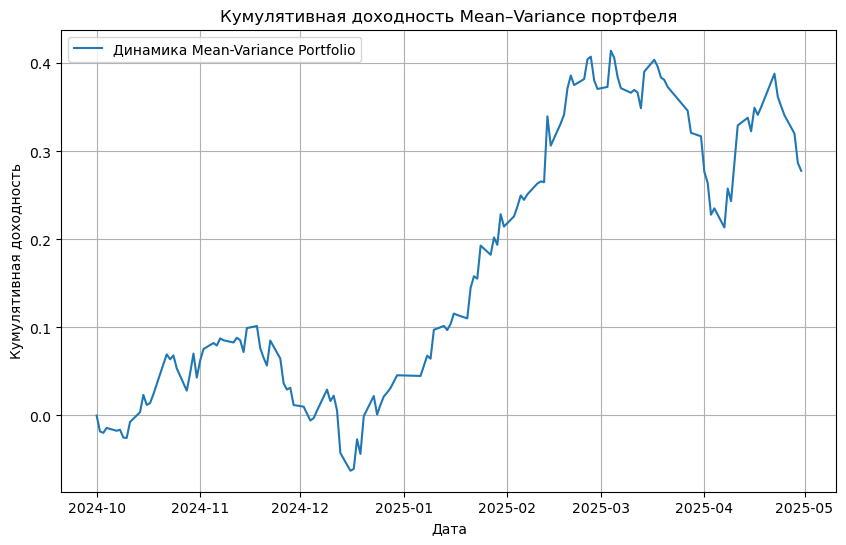

In [24]:
plt.figure(figsize=(10,6))
# plt.plot(cumulative, label='Динамика Mean-Variance Portfolio')
plt.plot(cumulative_with_zero, label='Динамика Mean-Variance Portfolio')
plt.title('Кумулятивная доходность Mean–Variance портфеля')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная доходность')
plt.legend()
plt.grid(True)
plt.show()